In [142]:
import sys,os
sys.path.insert(0, "D:/Dropbox/Progetti/SynthBurst")

In [143]:
import pandas as pd
import numpy as np
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_theme(style="white")
sns.set_context("notebook")

In [144]:
seeding = True

if seeding:
    seed_value = 66
    np.random.seed(seed_value)

In [145]:
import synthburst.simulate as sb

# Telemetry Budget Simulation

The idea is to simulate the photon lists for:
1. one hour of background data in band $50$-$300$ keV, according Riccardo's simulations. Results obtained from this simulation will be scaled up by a factor of $24$ to account for a full day of background acquisitions.
2. one full-band, bright burst with duration $\sim 50$ s and typical Band emission ($\alpha=-1$, $\beta=-2.33$, $E_p=174$).
3. one full-band, extremely bright burst with duration $\sim 50$ s and typical Band emission (as above).

Starting from these data we estimate:
1. the number of headers for each simulation, assuming that it is possible to accomodate a number of events `BUFFER_LEN` (nominally $8192$) before LAM, that each photons detected by scintillators results in two events and a new buffer file is created with period equal `BUFFER_REFRESH_S` (nominally $1$ s). 
2. the number of photons detected by SDDs (`X`).
3. the number of photons detected by scintillators (`S`).

Finally we compute the actual telemetry budget assuming that:
1. each header weights `HEADER_BITSIZE` bits (nominally set to 928). We will separately take into account headers optimization.
2. each `X` photon results in a single record event with dimension `SINGLE_EVENT_BITSIZE` (nominally 64 bit).
3. each `S` photon results in a double record event with dimension `DOUBLE_EVENT_BITSIZE` (nominally 96 bit).
This implies that event with multiplicity $> 2$ will be dealt with as event with multiplicity $= 2$.
4. telemetry of scientific ratemeters, separately for each quadrants and in three different bands.


### Data Format Specifications

In [146]:
SINGLE_EVENT_BITSIZE = 32 + 32 # TIME EVENT + PIXEL EVENT
DOUBLE_EVENT_BITSIZE = 32 + 2*32 # TIME EVENT + 2 PIXEL EVENT

HEADER_BITSIZE = 928
BUFFER_LEN = 8192
BUFFER_REFRESH_S = 1.0

### Constants

In [147]:
SECONDS_IN_A_DAY = 24*60*60
QUADRANTS_NUM = 4

## Background

We simulate one hour of HERMES background data.

In [148]:
lc = sb._LightCurveSim(duration = 60*60)
lc.add_bkg()

In [149]:
print("I've generated {} photons over {} seconds.".format(len(lc.data), lc.duration))

I've generated 3147754 photons over 3600 seconds.


We select all the events with energy between $50$ and $300$ keV.

In [150]:
band = (50,300)

In [151]:
events_num = len(lc.get_data(**{'energy' : band}))
rate = events_num/lc.duration
fraction_xevents = len(lc.get_data(flag = 'X', energy = band))/events_num
fraction_sevents = len(lc.get_data(flag = 'S', energy = band))/events_num
print("rate in band {} keV is: {:.2f} photons/s".format(band, rate))
print("of the simulated events {:.2f}% are X events,".format(100*fraction_xevents))
print("and {:.2f}% are S events.".format(100*fraction_sevents))

rate in band (50, 300) keV is: 73.95 photons/s
of the simulated events 2.10% are X events,
and 97.90% are S events.


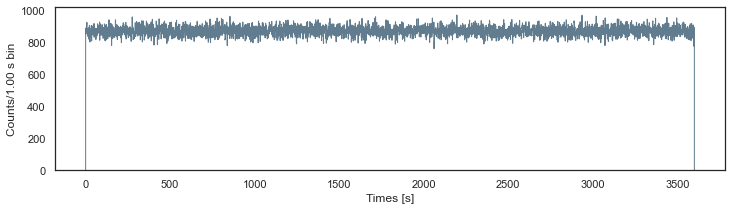

In [152]:
lc.plot(figsize = (12,3), binning = 1.)
plt.show()

We add a new column to track the ASICs (randomly generated) over which each event was observed, than we put the simulated photon events in a table container.

In [153]:
filtered_events = lc.get_data(**{'energy' : band})
events_table = pd.DataFrame(filtered_events,columns = ['TIME', 'ENERGY', 'FLAG'])
events_table['ASIC'] = np.random.randint(4, size = events_num);
events_table = events_table[events_table['ASIC'] < QUADRANTS_NUM]; events_table

,TIME,ENERGY,FLAG,ASIC
0,0.031444,40,S,1
1,0.072111,36,S,1
2,0.074277,28,S,3
3,0.120775,11,S,2
4,0.128223,12,S,1
...,...,...,...,...
266216,3599.909642,10,S,3
266217,3599.936558,21,S,3
266218,3599.943653,53,S,0
266219,3599.948745,23,S,0


The number of 'X' and 'S' events is:

In [154]:
num_xevents = len(events_table[events_table['FLAG'] == 'X']); print("num of X events is {}".format(num_xevents))
num_sevents = len(events_table[events_table['FLAG'] == 'S']); print("num of S events is {}".format(num_sevents))

num of X events is 5590
num of S events is 260631


We do now compute the number of headers needed to fully represent the event table.

In [155]:
def how_many_headers(duration, data_table, refresh_period, buffer_length):
    xdata_table = data_table[data_table['FLAG'] == 'X']
    sdata_table = data_table[data_table['FLAG'] == 'S']
    xasics_dtab = [xdata_table[xdata_table['ASIC'] == i] for i in range(QUADRANTS_NUM)]
    sasics_dtab = [sdata_table[sdata_table['ASIC'] == i] for i in range(QUADRANTS_NUM)]
    
    bins = np.arange(0, duration, refresh_period)
    out = []
    for t_i, t_f in zip(bins, bins + refresh_period):
        helper = []
        for asic in [0, 1, 2, 3]:
            xdf = xasics_dtab[asic]
            xevents = xdf[(xdf['TIME'] >= t_i) & (xdf['TIME'] < t_f) ]
            sdf = sasics_dtab[asic]
            sevents = sdf[(sdf['TIME'] >= t_i) & (sdf['TIME'] < t_f) ]

            num_events = len(xevents) + 2 * len(sevents)
            lam_headers = int(num_events / buffer_length)
            num_headers = 1 + lam_headers
            helper.append(num_headers)
        out.append(helper)

    n = sum([sum(sublist) for sublist in out])
    return n, out

In [156]:
num_headers, all_headers = how_many_headers(lc.duration, events_table, BUFFER_REFRESH_S, BUFFER_LEN)
print('number of headers in {}s is {}'.format(lc.duration, num_headers))

number of headers in 3600s is 14400


------
#### Minimal header information

The size of headers could be reduced without loss of information avoiding re-writing 87 bytes (same info for different quadrant) for three out of for quadrants at the pps. Using this information we can compute the minimal information content from the headers:

In [157]:
def minimal_headers_bitsize(headers, header_bits, rendundant_bits = 87*8):
    acc = 0
    for sublist in headers:
        headers_num = sum(sublist)
        assert headers_num - 4 >= 0
        acc += header_bits + 3*(header_bits - rendundant_bits) + header_bits*(headers_num - 4)
    return acc

Using this function we can compute the % of rendundant information:

In [158]:
redundant_fraction = (100*(HEADER_BITSIZE*num_headers - 
                           minimal_headers_bitsize(all_headers, HEADER_BITSIZE))
                         /(HEADER_BITSIZE*num_headers))
print("the redundant fraction in the headers is {:.2f}%".format(redundant_fraction))

the redundant fraction in the headers is 56.25%


--------

Finally we can compute the expected background telemetry, scaling our results to one day:

In [159]:
BACKGROUND_TELEMETRY_BITS = (num_headers*HEADER_BITSIZE + 
                             num_xevents*SINGLE_EVENT_BITSIZE + 
                             num_sevents*DOUBLE_EVENT_BITSIZE)
BACKGROUND_TELEMETRY_GBITS = BACKGROUND_TELEMETRY_BITS/10**9

BACKGROUND_DAILY_GBITS = BACKGROUND_TELEMETRY_GBITS*SECONDS_IN_A_DAY/lc.duration

print('expected background telemetry is {:.3f} Gbits/day'.format(BACKGROUND_DAILY_GBITS))

expected background telemetry is 0.930 Gbits/day


Which with minimal header could be reduced to:

In [160]:
BACKGROUND_MINH_TELEMETRY_BITS = (minimal_headers_bitsize(all_headers, HEADER_BITSIZE) + 
                             num_xevents*SINGLE_EVENT_BITSIZE + 
                             num_sevents*DOUBLE_EVENT_BITSIZE)
BACKGROUND_MINH_TELEMETRY_GBITS = BACKGROUND_MINH_TELEMETRY_BITS/10**9

BACKGROUND_MINH_DAILY_GBITS = BACKGROUND_MINH_TELEMETRY_GBITS*SECONDS_IN_A_DAY/lc.duration

print('expected background telemetry with minimal headers is {:.3f} Gbits/day'.format(BACKGROUND_MINH_DAILY_GBITS))

expected background telemetry with minimal headers is 0.749 Gbits/day


-----

## Burst telemetry

### Common burst telemetry

We use for our model a long GBM burst with duration around $50$ s.

In [161]:
model_id = '120707800'

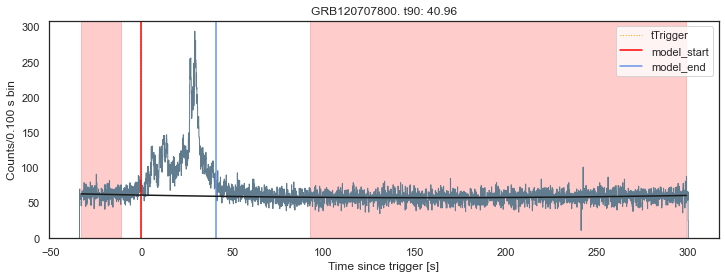

In [162]:
lc = sb.LCSFromModel() # create new sim
lc.simulate(model_id)  # set model 
lc.plot_model_diagnostic(figsize = (12,4), binning = 0.1) # plot diagnostics
plt.show()

The burst simulation parameters:

In [163]:
PREBURST = 30
POSTBURST = 0
BURSTDUR = 300
BURST_PHOTONS = 113145

In [164]:
lc = sb.LCSFromModel(duration = BURSTDUR + POSTBURST + PREBURST, burst_start_time = PREBURST)
lc.simulate(model_id, duration_adjust = (-8, 10))

In [165]:
lc.add_bkg() 
print("i've generated a total of {} background photons.".format(len(lc.get_data())))

i've generated a total of 288544 background photons.


In [166]:
lc.add_burst(BURST_PHOTONS)
print("i've generated a total of {} burst photons.".format(BURST_PHOTONS))

i've generated a total of 113145 burst photons.


A plot of the burst we just simulated:

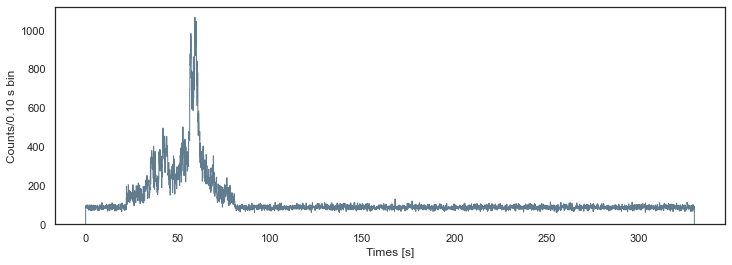

In [167]:
lc.plot(figsize = (12,4), binning = 0.1)
plt.show()

In [168]:
band = (0,2000)
events_num = len(lc.get_data(**{'energy' : band}))
rate = events_num/lc.duration
fraction_xevents = len(lc.get_data(flag = 'X', energy = band))/events_num
fraction_sevents = len(lc.get_data(flag = 'S', energy = band))/events_num
print("I've generated {} photons over {} seconds.".format(events_num, lc.duration))
print("rate in band {} keV is: {:.2f}".format(band, rate))
print("of these {:.2f}% are X events,".format(100*fraction_xevents))
print("and {:.2f}% are S events.".format(100*fraction_sevents))

I've generated 400913 photons over 330 seconds.
rate in band (0, 2000) keV is: 1214.89
of these 72.55% are X events,
and 27.45% are S events.


In [169]:
filtered_events = lc.get_data(**{'energy' : band})
events_table = pd.DataFrame(filtered_events,columns = ['TIME', 'ENERGY', 'FLAG'])
events_table['ASIC'] = np.random.randint(4, size = events_num);

In [170]:
num_xevents = len(events_table[events_table['FLAG'] == 'X']); print("num of X events is {}".format(num_xevents))
num_sevents = len(events_table[events_table['FLAG'] == 'S']); print("num of S events is {}".format(num_sevents))

num of X events is 290857
num of S events is 110056


In [171]:
num_headers, all_headers = how_many_headers(lc.duration, events_table, BUFFER_REFRESH_S, BUFFER_LEN)
print('number of headers is {}'.format(num_headers))

number of headers is 1320


In [172]:
COMMONBURST_TELEMETRY_BITS = (num_headers*HEADER_BITSIZE + 
                             num_xevents*SINGLE_EVENT_BITSIZE + 
                             num_sevents*DOUBLE_EVENT_BITSIZE)
COMMONBURST_TELEMETRY_GBITS = COMMONBURST_TELEMETRY_BITS/10**9

print('expected common burst telemetry is {:.5f} Gbits'.format(COMMONBURST_TELEMETRY_GBITS))

expected common burst telemetry is 0.03041 Gbits


The impact of minimal headers is small on burst telemetry:

In [173]:
COMMONBURST_MINH_TELEMETRY_BITS = (minimal_headers_bitsize(all_headers, HEADER_BITSIZE) + 
                                   num_xevents*SINGLE_EVENT_BITSIZE + 
                                   num_sevents*DOUBLE_EVENT_BITSIZE)
COMMONBURST_MINH_TELEMETRY_GBITS = COMMONBURST_MINH_TELEMETRY_BITS/10**9

print('expected common burst telemetry with minimal headers is {:.5f} Gbits'.format(COMMONBURST_MINH_TELEMETRY_GBITS))

expected common burst telemetry with minimal headers is 0.02972 Gbits


### Very bright burst

In [174]:
model_id = '120707800'

We use the same timing parameters as before but a larger number of events.

In [175]:
BURST_PHOTONS = 820050

In [176]:
lc = sb.LCSFromModel(duration = BURSTDUR + POSTBURST + PREBURST, burst_start_time = PREBURST)
lc.simulate(model_id, duration_adjust = (-8, 10))

In [177]:
lc.add_bkg() 
print("i've generated a total of {} background photons.".format(len(lc.get_data())))

i've generated a total of 288544 background photons.


In [178]:
lc.add_burst(BURST_PHOTONS)
print("i've generated a total of {} burst photons.".format(BURST_PHOTONS))

i've generated a total of 820050 burst photons.


In [179]:
band = (0,2000)
events_num = len(lc.get_data(**{'energy' : band}))
rate = events_num/lc.duration
fraction_xevents = len(lc.get_data(flag = 'X', energy = band))/events_num
fraction_sevents = len(lc.get_data(flag = 'S', energy = band))/events_num
print("rate in band {} keV is: {:.2f}".format(band, rate))
print("of these {:.2f}% are X events,".format(100*fraction_xevents))
print("and {:.2f}% are S events.".format(100*fraction_sevents))

rate in band (0, 2000) keV is: 3356.42
of these 60.32% are X events,
and 39.68% are S events.


In [180]:
filtered_events = lc.get_data(**{'energy' : band})
events_table = pd.DataFrame(filtered_events,columns = ['TIME', 'ENERGY', 'FLAG'])
events_table['ASIC'] = np.random.randint(4, size = events_num);

In [181]:
num_xevents = len(events_table[events_table['FLAG'] == 'X']); print("num of X events is {}".format(num_xevents))
num_sevents = len(events_table[events_table['FLAG'] == 'S']); print("num of S events is {}".format(num_sevents))

num of X events is 668061
num of S events is 439557


In [182]:
num_headers, all_headers = how_many_headers(lc.duration, events_table, BUFFER_REFRESH_S, BUFFER_LEN)
print('number of headers is {}'.format(num_headers))

number of headers is 1364


In [183]:
BRIGHTBURST_TELEMETRY_BITS = (num_headers*HEADER_BITSIZE + 
                             num_xevents*SINGLE_EVENT_BITSIZE + 
                             num_sevents*DOUBLE_EVENT_BITSIZE)
BRIGHTBURST_TELEMETRY_GBITS = BRIGHTBURST_TELEMETRY_BITS/10**9

print('expected very bright burst telemetry is {:.5f} Gbits'.format(BRIGHTBURST_TELEMETRY_GBITS))

expected very bright burst telemetry is 0.08622 Gbits


Again we have a small impact of minimal headers:

In [184]:
BRIGHTBURST_MINH_TELEMETRY_BITS = (minimal_headers_bitsize(all_headers, HEADER_BITSIZE) + 
                             num_xevents*SINGLE_EVENT_BITSIZE + 
                             num_sevents*DOUBLE_EVENT_BITSIZE)
BRIGHTBURST_MINH_TELEMETRY_GBITS = BRIGHTBURST_MINH_TELEMETRY_BITS/10**9

print('expected very bright burst telemetry with minimal headers is {:.5f} Gbits'.format(BRIGHTBURST_MINH_TELEMETRY_GBITS))

expected very bright burst telemetry with minimal headers is 0.08553 Gbits


## Scientific ratemeters

We use the latest (2022/09/09) model available: 8 bit counts for 3 bands and 4 quadrants plus 4 bytes of GPS per tenth, tenth of a second binning.

In [137]:
SR_REFRESH_PERIOD = 0.1 # seconds
SR_COUNTS_BITSIZE = 8
SR_GPS_BITSIZE = 4*8
SR_BANDS = 3

SR_TELEMETRY_BITS = (QUADRANTS_NUM*SR_COUNTS_BITSIZE*SR_BANDS/SR_REFRESH_PERIOD + SR_GPS_BITSIZE)*(SECONDS_IN_A_DAY)
SR_TELEMETRY_GBITS = SR_TELEMETRY_BITS/10**9
print("the SR daily telemetry is {} Gbit.".format(SR_TELEMETRY_GBITS))

the SR daily telemetry is 0.0857088 Gbit.


Note that the calcuations above (as well as those from 2022/09/09) assume that the GPS header is formed only one a second, regardless of the SR binning.

# Conclusions

The estimated total daily budget is :

In [138]:
TOTAL_BUDGET_GBITS = (BRIGHTBURST_TELEMETRY_GBITS + 
                      COMMONBURST_TELEMETRY_GBITS + 
                      BACKGROUND_DAILY_GBITS + 
                      SR_TELEMETRY_GBITS)

print("the total daily budget is {:.2f} Gbit."
      .format(TOTAL_BUDGET_GBITS))

the total daily budget is 1.13 Gbit.


Minimizing header information, we can reach:

In [139]:
TOTAL_MINH_BUDGET_GBITS = (BRIGHTBURST_MINH_TELEMETRY_GBITS + 
                      COMMONBURST_MINH_TELEMETRY_GBITS + 
                      BACKGROUND_MINH_DAILY_GBITS + 
                      SR_TELEMETRY_GBITS)

print("the total daily budget with minimal headers is {:.2f} Gbit."
      .format(TOTAL_MINH_BUDGET_GBITS))

the total daily budget with minimal headers is 0.95 Gbit.


Note that this calculation does not include any margin. On the brightside however, the impact of LAMs on the telemetry is taken into account, at least to some degree. Indeed, the present estimate of LAM headers is an underestimate due to the assumptions that the maximum event multiplicity equals 2. This situation can be improved providing an estimate of the incidence of high multiplicity events relative to single/double events.

Considering a 30% margin we obtain:

In [140]:
MARGIN = 30
MARGIN_BUDGET_GBITS = (BRIGHTBURST_TELEMETRY_GBITS + 
                      COMMONBURST_TELEMETRY_GBITS + 
                      BACKGROUND_DAILY_GBITS)*MARGIN/100
MARGIN_MINH_BUDGET_GBITS = (BRIGHTBURST_MINH_TELEMETRY_GBITS + 
                      COMMONBURST_MINH_TELEMETRY_GBITS + 
                      BACKGROUND_MINH_DAILY_GBITS)*MARGIN/100

print("the total daily budget with {}% margin is {:.2f} Gbit."
      .format(MARGIN, TOTAL_BUDGET_GBITS + MARGIN_BUDGET_GBITS))
print("the total daily budget with minimal headers and {}% margin is {:.2f} Gbit."
      .format(MARGIN, TOTAL_MINH_BUDGET_GBITS + MARGIN_MINH_BUDGET_GBITS))

the total daily budget with 30% margin is 1.45 Gbit.
the total daily budget with minimal headers and 30% margin is 1.21 Gbit.


For a 95% margin:

In [141]:
MARGIN = 95
MARGIN_BUDGET_GBITS = (BRIGHTBURST_TELEMETRY_GBITS + 
                      COMMONBURST_TELEMETRY_GBITS + 
                      BACKGROUND_DAILY_GBITS)*MARGIN/100
MARGIN_MINH_BUDGET_GBITS = (BRIGHTBURST_MINH_TELEMETRY_GBITS + 
                      COMMONBURST_MINH_TELEMETRY_GBITS + 
                      BACKGROUND_MINH_DAILY_GBITS)*MARGIN/100

print("the total daily budget with {}% margin is {:.2f} Gbit."
      .format(MARGIN, TOTAL_BUDGET_GBITS + MARGIN_BUDGET_GBITS))
print("the total daily budget with minimal headers and {}% margin is {:.2f} Gbit."
      .format(MARGIN, TOTAL_MINH_BUDGET_GBITS + MARGIN_MINH_BUDGET_GBITS))

the total daily budget with 95% margin is 2.13 Gbit.
the total daily budget with minimal headers and 95% margin is 1.77 Gbit.
